# State estimation with unknown $\mathbf{A}$ and $\gamma$
## Model specification
$$p(\mathbf{x, y, a, \gamma}) = p(\mathbf{x}_0)p(\mathbf{a})p(\gamma_x)p(\gamma_y)\prod_{n=1}^Np(\mathbf{x}_n|\mathbf{x}_{n-1}, \mathbf{a, \gamma_x})p(y_n|\mathbf{x}_n, \gamma_y)$$

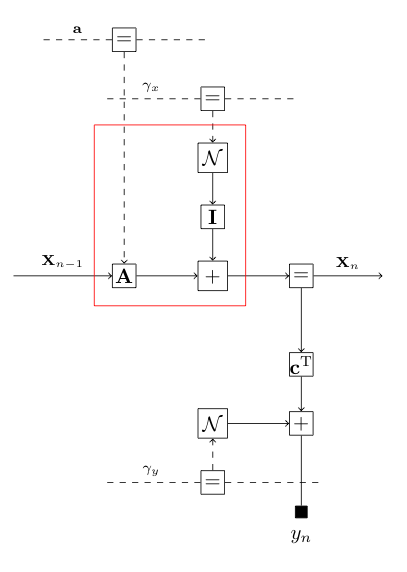

In [475]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$, the precision  of the driving noise $\gamma_x$ and the states $\mathbf{x}_n$, $\mathbf{x}_{n-1}$.

In [3]:
using ProgressMeter
using Revise
using ForneyLab
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [6]:
ARorder = 5 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# Coefs and real states
coefs, x = generate_data(1000, ARorder, 1, noise_variance=1.0)
#x = use_data("data/daily-minimum-temperatures.csv", ARorder)
#x = [reverse(x) for x in x]
# Observations
#measurement_noise = 3.0
#y = [xi[1] + sqrt(measurement_noise)*randn() for xi in x[ARorder:end]]

MethodError: MethodError: no method matching -(::Array{Float64,1}, ::Float64)
Closest candidates are:
  -(!Matched::Float64, ::Float64) at float.jl:397
  -(!Matched::Complex{Bool}, ::Real) at complex.jl:298
  -(!Matched::Missing, ::Number) at missing.jl:97
  ...

In [2]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV a_w_t
@RV b_w_t
@RV m_a_t
@RV w_a_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w_t, b_w_t)
@RV x_t = AR(a, x_t_prev, w)
#@RV n ~ GaussianMeanPrecision(0.0, measurement_noise^-1)
c = zeros(ARorder); c[1] = 1.0
@RV y_t = dot(c, x_t)

# Placeholders for prior
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(a_w_t, :a_w_t)
placeholder(b_w_t, :b_w_t)
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(y_t, :y_t)

UndefVarError: UndefVarError: FactorGraph not defined

In [668]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, w, ids=[:A, :X_t, :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepX_t! (generic function with 3 methods)

In [697]:
# Define values for prior statistics
m_x_prev_0 = randn(ARorder)
w_x_prev_0 = (0.0001*diagAR(ARorder))
a_w_0 = 0.00001
b_w_0 = 0.00001
m_a_0 =  randn(ARorder)
w_a_0 =  (0.01*diagAR(ARorder));

In [698]:
# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(y))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(y))
a_w = Vector{Float64}(undef, length(y))
b_w = Vector{Float64}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
a_w_t_min = a_w_0
b_w_t_min = b_w_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [705]:
marginals = Dict()
n_its = 10

p = Progress(length(y), 1, "Observed ")
for t = 1:length(y)
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_t_min, b=b_w_t_min)
    for i = 1:n_its
        data = Dict(:y_t   => y[t],
                    :m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :a_w_t => a_w_t_min,
                    :b_w_t => b_w_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min)

        stepX_t!(data, marginals)
        stepA!(data, marginals)
        #stepW!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x_prev[t] = unsafeMean(marginals[:x_t])
        w_x_prev[t] = unsafePrecision(marginals[:x_t])
        a_w[t] = marginals[:w].params[:a]
        b_w[t] = marginals[:w].params[:b]
        # Store to buffer
        m_a_t_min = m_a[t]
        w_a_t_min = w_a[t]
        m_x_t_prev_min = m_x_prev[t]
        w_x_t_prev_min = w_x_prev[t]
        a_w_t_min = a_w[t]
        b_w_t_min = b_w[t]
    end
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:02


In [706]:
# MSE analysis
from = 1
predicted = [x[1] for x in m_x_prev[from:end]]
actual = [x[1] for x in x[ARorder:end]]
noise = [y[1] for y in y[from:end]]

println("Δ(predicted, actual)=", mse(predicted, actual))
println("Δ(predicted, noise)=", mse(predicted, noise))
println("Δ(noise, actual)=", mse(noise, actual))

Δ(predicted, actual)=3.2449877662712527
Δ(predicted, noise)=2.997642615693943e-8
Δ(noise, actual)=3.2449947654834403


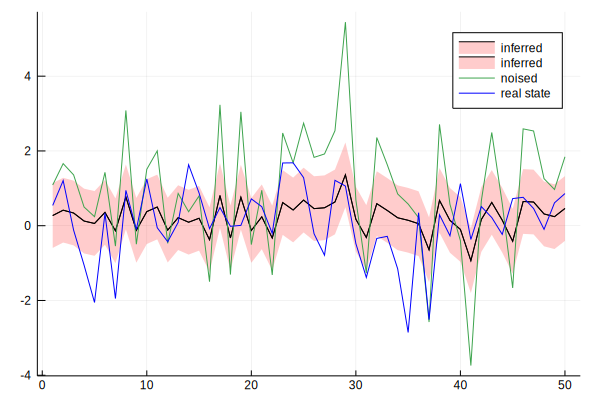

In [702]:
# Plotting
using Plots
upto = 50 # limit for building a graph
scale = 1.0 # scale for the variance
#insert!(predicted, 1, m_x_prev_0[1])
v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
#insert!(v_x, 1, w_x_prev_0[1]^-1)
plot([predicted[1:upto], predicted[1:upto]], fillrange=[predicted[1:upto] -
      scale .* sqrt.(v_x[1:upto]), predicted[1:upto] +
      scale .* sqrt.(v_x[1:upto])],
      color=:black,
      fillalpha = 0.2,
      fillcolor = :red,
      label=["inferred", "inferred"])
plot!(noise[1:upto], label="noised")
plot!(actual[1:upto], label="real state", color=:blue)
#ylims!(-10, 10)

In [703]:
mean(marginals[:x_t_prev])

5-element Array{Float64,1}:
 -0.6619446819734769 
  0.2731393589622405 
  1.4216893532111248 
 -0.10218661620759538
 -0.11096978579054328

In [704]:
mean(marginals[:a])

5-element Array{Float64,1}:
  0.002718460183398906 
  0.0012159773947375897
 -0.0015129028438112895
  0.004623481035767371 
  0.002820535787499191 

In [642]:
mean(marginals[:w])^-1

1.0

In [689]:
coefs

5-element Array{Float64,1}:
  0.29057223163891066
  0.06721870673044737
 -0.303850749401607  
  0.46094370243254235
  0.11330571632221058